In [1]:
### Imports ###
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import acquire
import wrangle
import modeling

# Outline
This is where I put things that have worked- it's an intermediary between the draft workspace and final notebook.

# Acquire
**MVP columns** from data: Parcel.ID, County, Latitude, Longitude, Home.Value, Baths, Beds, Finished.Area

# Wrangle

In [2]:
# # Full results with outliers
# df_out, X_train_exp_out,\
# X_train_out, y_train_out,\
# X_validate_out, y_validate_out,\
# X_test_out, y_test_out = wrangle.wrangle_zillow_MVP_keep_outliers()

# Full results with outliers removed via IQR
df, X_train_exp,\
X_train, y_train,\
X_validate, y_validate,\
X_test, y_test = wrangle.wrangle_zillow_MVP()

print(X_train_exp.shape)
df.head(3)

(27504, 17)


,Parcel.ID,County,Latitude,Longitude,Home.Value,Prediction.Error,Baths,Beds,Finished.Area,is_coastal,cool_places
0,14297519,Orange,33634931,-117869207,1023282,0.025595,3.5,4.0,3100,False,False
1,17052889,Ventura,34449266,-119281531,464000,0.055619,1.0,2.0,1465,False,False
2,14186244,Orange,33886168,-117823170,564778,0.005383,2.0,3.0,1243,False,False


# Explore

- 1 with 4 digits: 9% of properties, 17/15 h, 15/20 v, 16/20 a, good box
- 2 with 4 digits: unimpressive
- 3 with 4 digits: 2.7% of properties, 16/19 h, 16/20 v, 16/24 a, good box
- 4 with 4 digits: 1.9% of properties, 16/21 h, 16/19 v, 17/21 a, even box
- **5 with 4 digits**: 1.4% of properties, 16/25 h, 17/18 v, **16/33 a**, good box
- 6 with 4 digits: 1.2% of properties, 16/22 h, 17/16 v, 17/21 a, good box
- 7 with 4 digits: 1.0% of properties, 16/25 h, 16/23 v, 16/36 a, good box
- 8 with 4 digits: bad box
- 9 with 4 digits: 

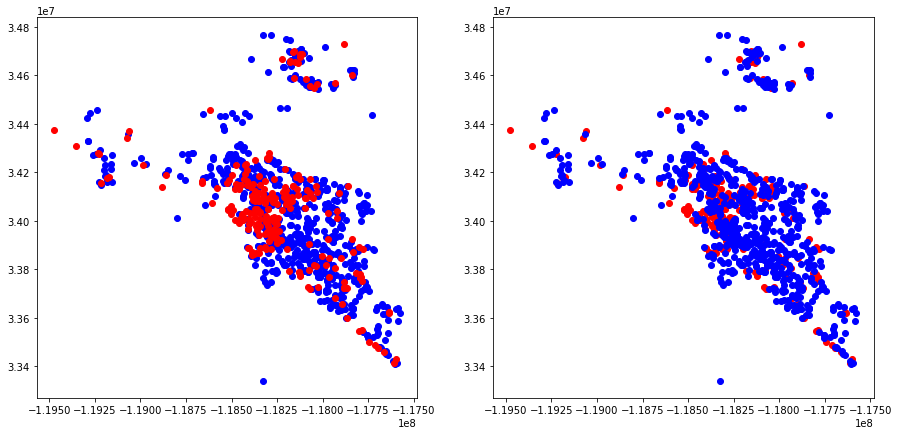

In [3]:
plt.figure(figsize=(15,7))
plt.subplot(121)
plt.scatter(X_train_exp[X_train_exp['Prediction.Error'] > 0.3].Longitude, X_train_exp[X_train_exp['Prediction.Error'] > 0.3].Latitude, c='blue')
plt.scatter(X_train_exp[X_train_exp['Prediction.Error'] < -0.3].Longitude, X_train_exp[X_train_exp['Prediction.Error'] < -0.3].Latitude, c='red')

plt.subplot(122)
plt.scatter(X_train_exp[X_train_exp['Prediction.Error'] < -0.3].Longitude, X_train_exp[X_train_exp['Prediction.Error'] < -0.3].Latitude, c='red')
plt.scatter(X_train_exp[X_train_exp['Prediction.Error'] > 0.3].Longitude, X_train_exp[X_train_exp['Prediction.Error'] > 0.3].Latitude, c='blue')

In [4]:
X_train_exp['square'] = (X_train_exp.Latitude > 33850000) & (X_train_exp.Latitude < 34000000) & (X_train_exp.Longitude > -118200000) & (X_train_exp.Longitude < -118000000)
X_train_exp['rectangle'] = (X_train_exp.Latitude > 33950000) & (X_train_exp.Latitude < 34070000) & (X_train_exp.Longitude > -118150000) & (X_train_exp.Longitude < -117650000)
X_train_exp['diagonal_0'] = (X_train_exp.Latitude > 34150000) & (X_train_exp.Latitude < 34200000) & (X_train_exp.Longitude > -118650000) & (X_train_exp.Longitude < -118560000)
X_train_exp['diagonal_1'] = (X_train_exp.Latitude > 34190000) & (X_train_exp.Latitude < 34210000) & (X_train_exp.Longitude > -118650000) & (X_train_exp.Longitude < -118480000)
X_train_exp['diagonal_2'] = (X_train_exp.Latitude > 34220000) & (X_train_exp.Latitude < 34350000) & (X_train_exp.Longitude > -118650000) & (X_train_exp.Longitude < -118340000)

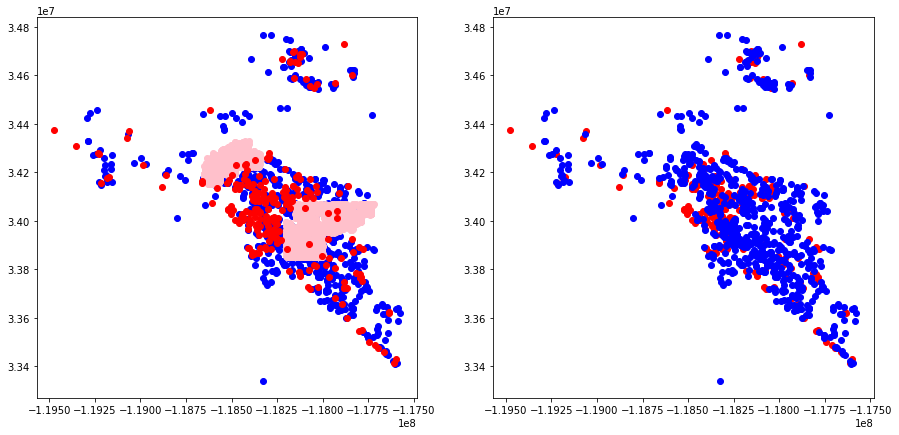

In [5]:
plt.figure(figsize=(15,7))
plt.subplot(121)
plt.scatter(X_train_exp[X_train_exp['Prediction.Error'] > 0.3].Longitude, X_train_exp[X_train_exp['Prediction.Error'] > 0.3].Latitude, c='blue')
plt.scatter(X_train_exp[X_train_exp['square']].Longitude, X_train_exp[X_train_exp['square']].Latitude, c='pink')
plt.scatter(X_train_exp[X_train_exp['rectangle']].Longitude, X_train_exp[X_train_exp['rectangle']].Latitude, c='pink')
plt.scatter(X_train_exp[X_train_exp['diagonal_0']].Longitude, X_train_exp[X_train_exp['diagonal_0']].Latitude, c='pink')
plt.scatter(X_train_exp[X_train_exp['diagonal_1']].Longitude, X_train_exp[X_train_exp['diagonal_1']].Latitude, c='pink')
plt.scatter(X_train_exp[X_train_exp['diagonal_2']].Longitude, X_train_exp[X_train_exp['diagonal_2']].Latitude, c='pink')
plt.scatter(X_train_exp[X_train_exp['Prediction.Error'] < -0.3].Longitude, X_train_exp[X_train_exp['Prediction.Error'] < -0.3].Latitude, c='red')

plt.subplot(122)
plt.scatter(X_train_exp[X_train_exp['Prediction.Error'] < -0.3].Longitude, X_train_exp[X_train_exp['Prediction.Error'] < -0.3].Latitude, c='red')
plt.scatter(X_train_exp[X_train_exp['Prediction.Error'] > 0.3].Longitude, X_train_exp[X_train_exp['Prediction.Error'] > 0.3].Latitude, c='blue')

### Southern Portion (Positive Error)

In [6]:
X_train_exp['relaxed_lat'] = 2 * round(X_train_exp['Latitude'] / 2000000, 4)
X_train_exp['relaxed_long'] = 2 * round(X_train_exp['Longitude'] / 2000000, 4)
print('Number of rows:', len(X_train_exp))
print('Unique latitudes:', len(X_train_exp['relaxed_lat'].unique()))
print('Unique longitudes:', len(X_train_exp['relaxed_long'].unique()))

Number of rows: 27504
Unique latitudes: 5482
Unique longitudes: 6754


In [7]:
latlong_dict = dict(X_train_exp.groupby('relaxed_lat').Longitude.min())
longlat_dict = dict(X_train_exp.groupby('relaxed_long').Latitude.min())

In [8]:
X_train_exp['is_coastal_horizontal'] = ((X_train_exp['relaxed_lat'] <= 33.9) & 
                              (X_train_exp['relaxed_lat'].apply(lambda x: latlong_dict.get(x)) == X_train_exp['Longitude']))
    
X_train_exp['is_coastal_vertical'] = ((X_train_exp['relaxed_long'] >= -118.40) & 
                            (X_train_exp['relaxed_long'].apply(lambda x: longlat_dict.get(x)) == X_train_exp['Latitude']))

print('Horizontal Mean:', X_train_exp['is_coastal_horizontal'].mean())
print('Horizontal Error:', X_train_exp.groupby('is_coastal_horizontal')['Prediction.Error'].mean())
print('Vertical Mean:', X_train_exp['is_coastal_vertical'].mean())
print('Vertical Error:', X_train_exp.groupby('is_coastal_vertical')['Prediction.Error'].mean())

Horizontal Mean: 0.07678883071553229
Horizontal Error: is_coastal_horizontal
False    0.016337
True     0.025994
Name: Prediction.Error, dtype: float64
Vertical Mean: 0.14819662594531705
Vertical Error: is_coastal_vertical
False    0.016544
True     0.020154
Name: Prediction.Error, dtype: float64


In [9]:
X_train_exp['is_coastal'] = X_train_exp['is_coastal_vertical'] & X_train_exp['is_coastal_horizontal']
print('Mean:', X_train_exp['is_coastal'].mean())
print('Error:', X_train_exp.groupby('is_coastal')['Prediction.Error'].mean())

Mean: 0.04173938336242001
Error: is_coastal
False    0.016723
True     0.025231
Name: Prediction.Error, dtype: float64


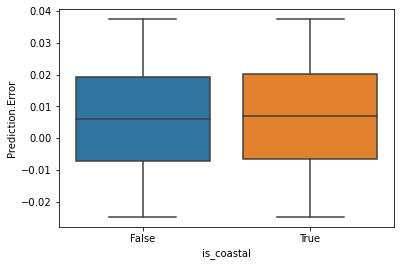

In [10]:
q1, q3 = X_train_exp['Prediction.Error'].quantile([0.25, 0.75])
mask = (X_train_exp['Prediction.Error'] > q1) & (X_train_exp['Prediction.Error'] < q3)
sns.boxplot(X_train_exp[mask]['is_coastal'], X_train_exp[mask]['Prediction.Error'])
plt.show()

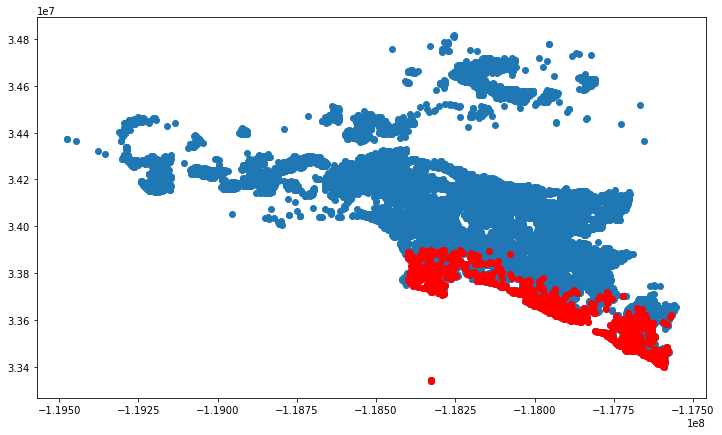

In [11]:
plt.figure(figsize=(12,7))
plt.scatter(X_train_exp.Longitude, X_train_exp.Latitude)
plt.scatter(X_train_exp[X_train_exp.is_coastal].Longitude, X_train_exp[X_train_exp.is_coastal].Latitude, c='red')

In [12]:
X_train_exp['cool_places'] = (X_train_exp['is_coastal'] | X_train_exp['square'] | X_train_exp['rectangle'] | 
                     X_train_exp['diagonal_0'] | X_train_exp['diagonal_1'] | X_train_exp['diagonal_2'])

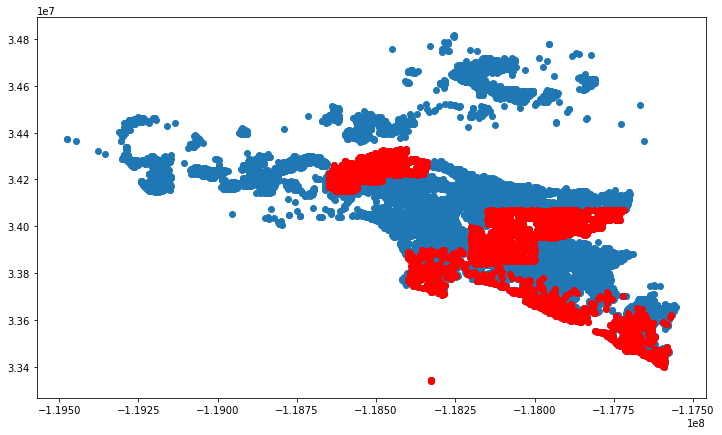

In [13]:
plt.figure(figsize=(12,7))
plt.scatter(X_train_exp.Longitude, X_train_exp.Latitude)
plt.scatter(X_train_exp[X_train_exp.cool_places].Longitude, X_train_exp[X_train_exp.cool_places].Latitude, c='red')

In [14]:
print("% of total properties:", X_train_exp.cool_places.mean())
X_train_exp.groupby('cool_places')['Prediction.Error'].mean()

% of total properties: 0.22429464805119256


cool_places
False    0.015578
True     0.022267
Name: Prediction.Error, dtype: float64

<AxesSubplot:xlabel='cool_places', ylabel='Prediction.Error'>

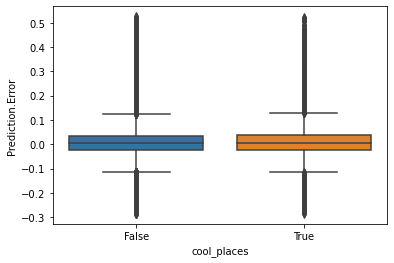

In [15]:
q1, q3 = X_train_exp['Prediction.Error'].quantile([0.01, 0.99])
mask = (X_train_exp['Prediction.Error'] > q1) & (X_train_exp['Prediction.Error'] < q3)
sns.boxplot(X_train_exp[mask]['cool_places'], X_train_exp[mask]['Prediction.Error'])

In [16]:
X_train_exp = X_train_exp.drop(columns=['square','rectangle',
                 'diagonal_0','diagonal_1','diagonal_2',
                 'relaxed_lat','relaxed_long',
                 'is_coastal_horizontal',
                 'is_coastal_vertical',])

X_train_exp.head(3)

,Parcel.ID,County,Latitude,Longitude,Home.Value,Baths,Beds,Finished.Area,is_coastal,cool_places,Prediction.Error,Home.Value.Scaled,Baths.Scaled,Beds.Scaled,Finished.Area.Scaled,Is.Coastal.Scaled,Is.Cool.Place.Scaled
9816,14433972,Orange,33494840,-117693964,1032894,3.5,3.0,2841,False,False,0.064047,2.545324,1.926880,-0.261993,1.894494,0.152861,0.508689
40848,14037584,Orange,33742714,-118017115,59427,2.0,4.0,1182,False,False,0.012524,-1.244041,-0.133840,1.008879,-0.854941,0.152861,0.508689
38048,11693178,LA,33992973,-118287389,238563,1.0,3.0,2628,False,False,0.098879,-0.546727,-1.507654,-0.261993,1.541492,0.152861,0.508689


# Modeling

In [17]:
X_train[:3]

array([[ 2.54532438,  1.92688046, -0.26199261,  1.89449362,  0.15286128,
         0.50868881],
       [-1.24404075, -0.13383993,  1.00887947, -0.85494106,  0.15286128,
         0.50868881],
       [-0.54672722, -1.50765353, -0.26199261,  1.54149206,  0.15286128,
         0.50868881]])

In [18]:
y_train[:3]

,Prediction.Error
9816,0.064047
40848,0.012524
38048,0.098879


In [19]:
X_validate[:3]

array([[-0.20700408,  1.23997366,  1.00887947,  1.54977848,  0.15286128,
         0.50868881],
       [-0.13954837, -0.13383993, -0.26199261, -0.54005704,  0.15286128,
         0.50868881],
       [ 0.09920724, -0.13383993, -0.26199261,  0.78079856,  0.15286128,
         0.50868881]])

In [20]:
y_train = y_train.rename(columns={'Prediction.Error':'actuals'})
y_validate = y_validate.rename(columns={'Prediction.Error':'actuals'})

In [21]:
# Cheating?
y_train, y_validate = modeling.regression_shotgun(X_train, y_train, X_validate, y_validate)
# Not Cheating?
y_train2, y_validate2 = modeling.regression_shotgun(X_train[:,(0,1,2,3,4)], y_train, X_validate[:,(0,1,2,3,4)], y_validate)

In [22]:
running_df = modeling.y_df_RMSE_r2(y_train, y_validate)
running_df2 = modeling.y_df_RMSE_r2(y_train2, y_validate2)

**OLS (Linear Regression)**: 
- baseline: train RMSE: 0.1701, validate RMSE: 0.1616
- (cheating?): train RMSE: 0.1699, validate RMSE: 0.1614, train_r2: 0.0019, val_r2 = 0.0035
- (not cheating?): train RMSE: 0.1699, validate RMSE: 0.1614, train_r2: 0.0017, val_r2 = 0.0028

Without clustering, my best performing model (I think I cheated a bit on it with cool_places) was the **Linear Regression model**.

# Clustering

In [23]:
kmeans = KMeans(n_clusters=5, random_state=123)

In [24]:
kmeans.fit(X_train[:,(0,3,4)]) # Home value, finished area, and is_coastal for cluster

KMeans(n_clusters=5, random_state=123)

In [25]:
X_train_exp['worth_area_coast_5cluster'] = kmeans.predict(X_train[:,(0,3,4)])

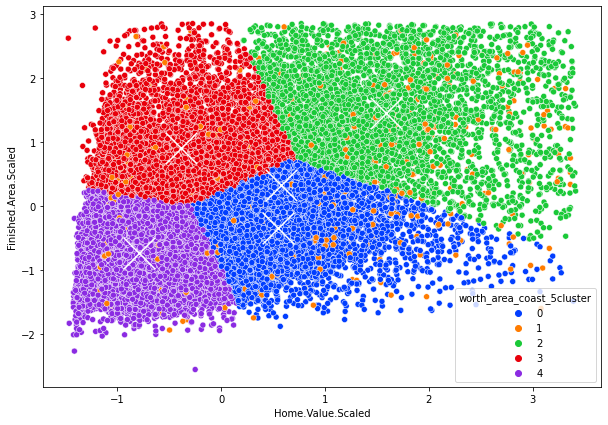

In [26]:
centroids = X_train_exp.groupby('worth_area_coast_5cluster')['Home.Value.Scaled','Finished.Area.Scaled'].mean()
plt.figure(figsize=(10,7))
sns.scatterplot(data=X_train_exp, x='Home.Value.Scaled', y='Finished.Area.Scaled', hue='worth_area_coast_5cluster', palette='bright')
centroids.plot.scatter(x='Home.Value.Scaled', y='Finished.Area.Scaled', marker='x', s=1000, ax=plt.gca(), c='white')
plt.show()

In [27]:
X_train_exp.groupby('worth_area_coast_5cluster')['Prediction.Error'].mean()

worth_area_coast_5cluster
0    0.005731
1    0.032139
2    0.025251
3    0.021688
4    0.018597
Name: Prediction.Error, dtype: float64

In [28]:
X_train_exp['is_cluster0'] = X_train_exp['worth_area_coast_5cluster'] == 0
X_train_exp.head(1)

,Parcel.ID,County,Latitude,Longitude,Home.Value,Baths,Beds,Finished.Area,is_coastal,cool_places,Prediction.Error,Home.Value.Scaled,Baths.Scaled,Beds.Scaled,Finished.Area.Scaled,Is.Coastal.Scaled,Is.Cool.Place.Scaled,worth_area_coast_5cluster,is_cluster0
9816,14433972,Orange,33494840,-117693964,1032894,3.5,3.0,2841,False,False,0.064047,2.545324,1.92688,-0.261993,1.894494,0.152861,0.508689,2,False


## Model with is_cluster0 feature

In [29]:
columns_to_scale = ['Home.Value', 'Baths', 'Beds', 'Finished.Area', 'is_coastal']
train, validate, test = wrangle.split_data(df)
X_train, y_train,\
X_validate, y_validate,\
X_test, y_test = wrangle.isolate_zillow_target('Prediction.Error', train, validate, test)
X_train.head(3)

,Parcel.ID,County,Latitude,Longitude,Home.Value,Baths,Beds,Finished.Area,is_coastal,cool_places
9816,14433972,Orange,33494840,-117693964,1032894,3.5,3.0,2841,False,False
40848,14037584,Orange,33742714,-118017115,59427,2.0,4.0,1182,False,False
38048,11693178,LA,33992973,-118287389,238563,1.0,3.0,2628,False,False


In [30]:
scaler = StandardScaler()
X_train_c0 = scaler.fit_transform(X_train[columns_to_scale])
X_train[['Home.Value.Scaled', 
        'Baths.Scaled', 
        'Beds.Scaled', 
        'Finished.Area.Scaled', 
        'Is.Coastal.Scaled']] = X_train_c0

X_validate_c0 = scaler.transform(X_validate[columns_to_scale])
X_validate[['Home.Value.Scaled', 
            'Baths.Scaled', 
            'Beds.Scaled', 
            'Finished.Area.Scaled', 
            'Is.Coastal.Scaled']] = X_validate_c0
X_test_c0 = scaler.transform(X_test[columns_to_scale])
X_test[['Home.Value.Scaled', 
        'Baths.Scaled', 
        'Beds.Scaled', 
        'Finished.Area.Scaled', 
        'Is.Coastal.Scaled']] = X_test_c0

In [31]:
kmeans_c0 = KMeans(n_clusters=5, random_state=123)
kmeans_c0.fit(X_train_c0)

KMeans(n_clusters=5, random_state=123)

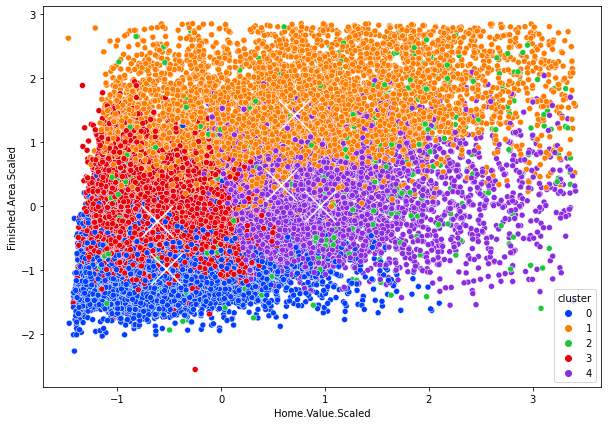

In [32]:
X_train['cluster'] = kmeans_c0.predict(X_train_c0)
centroids = X_train.groupby('cluster')['Home.Value.Scaled','Finished.Area.Scaled'].mean()
plt.figure(figsize=(10,7))
sns.scatterplot(data=X_train, x='Home.Value.Scaled', y='Finished.Area.Scaled', hue='cluster', palette='bright')
centroids.plot.scatter(x='Home.Value.Scaled', y='Finished.Area.Scaled', marker='x', s=1000, ax=plt.gca(), c='white')
plt.show()

In [33]:
pd.concat([X_train, y_train], axis=1).groupby('cluster')['Prediction.Error'].mean()

cluster
0    0.014929
1    0.027505
2    0.032139
3    0.017164
4    0.005693
Name: Prediction.Error, dtype: float64

For this, it's cluster 4

In [34]:
X_validate.head(3)

,Parcel.ID,County,Latitude,Longitude,Home.Value,Baths,Beds,Finished.Area,is_coastal,cool_places,Home.Value.Scaled,Baths.Scaled,Beds.Scaled,Finished.Area.Scaled,Is.Coastal.Scaled
26571,10867024,LA,34153026,-118492319,325836,3.0,4.0,2633,False,False,-0.207004,1.239974,1.008879,1.549778,-0.152861
25301,17257236,Ventura,34277306,-118699466,343165,2.0,3.0,1372,False,False,-0.139548,-0.133840,-0.261993,-0.540057,-0.152861
47064,17157913,Ventura,34185920,-119239848,404500,2.0,3.0,2169,False,False,0.099207,-0.133840,-0.261993,0.780799,-0.152861


In [35]:
X_train['is_cluster4'] = X_train['cluster'] == 4
arraying_cluster = [[x] for x in X_train['is_cluster4']]
X_train_c0 = np.append(X_train_c0, arraying_cluster, axis=1)
X_train_c0

array([[ 2.54532438,  1.92688046, -0.26199261,  1.89449362, -0.15286128,
         0.        ],
       [-1.24404075, -0.13383993,  1.00887947, -0.85494106, -0.15286128,
         0.        ],
       [-0.54672722, -1.50765353, -0.26199261,  1.54149206, -0.15286128,
         0.        ],
       ...,
       [-0.87075908,  1.23997366, -0.26199261,  0.55872246, -0.15286128,
         0.        ],
       [-0.34904683, -0.13383993, -0.26199261, -0.88477218, -0.15286128,
         0.        ],
       [ 0.4066175 ,  0.55306686,  1.00887947,  1.87294892, -0.15286128,
         0.        ]])

In [36]:
X_validate['cluster'] = kmeans_c0.predict(X_validate_c0)
X_validate['is_cluster4'] = X_validate['cluster'] == 4
arraying_cluster = [[x] for x in X_validate['is_cluster4']]
X_validate_c0 = np.append(X_validate_c0, arraying_cluster, axis=1)
X_validate_c0

array([[-0.20700408,  1.23997366,  1.00887947,  1.54977848, -0.15286128,
         0.        ],
       [-0.13954837, -0.13383993, -0.26199261, -0.54005704, -0.15286128,
         0.        ],
       [ 0.09920724, -0.13383993, -0.26199261,  0.78079856, -0.15286128,
         1.        ],
       ...,
       [-0.48982837, -0.13383993, -0.26199261,  0.1427441 , -0.15286128,
         0.        ],
       [ 0.80383896,  1.23997366,  1.00887947,  2.19114751, -0.15286128,
         0.        ],
       [ 2.07083385,  1.23997366, -0.26199261,  1.93095387, -0.15286128,
         0.        ]])

In [37]:
X_test['cluster'] = kmeans_c0.predict(X_test_c0)
X_test['is_cluster4'] = X_test['cluster'] == 4
arraying_cluster = [[x] for x in X_test['is_cluster4']]
X_test_c0 = np.append(X_test_c0, arraying_cluster, axis=1)
X_test_c0

array([[ 0.95042054,  0.55306686,  1.00887947,  1.28792756, -0.15286128,
         0.        ],
       [-0.59096328, -0.13383993,  1.00887947,  0.23555202, -0.15286128,
         0.        ],
       [ 1.38962031,  1.23997366, -0.26199261,  0.78245584, -0.15286128,
         1.        ],
       ...,
       [ 0.24128893, -0.13383993, -1.53286469, -0.41410343, -0.15286128,
         1.        ],
       [-0.59275389, -0.13383993, -0.26199261, -1.05050061, -0.15286128,
         0.        ],
       [ 1.25786972,  1.23997366,  2.27975155,  2.56900833, -0.15286128,
         0.        ]])

In [38]:
y_train = y_train.rename(columns={'Prediction.Error':'actuals'})
y_validate = y_validate.rename(columns={'Prediction.Error':'actuals'})

In [39]:
y_train, y_validate = modeling.regression_shotgun(X_train_c0, y_train, X_validate_c0, y_validate)

In [40]:
running_df = modeling.y_df_RMSE_r2(y_train, y_validate)

In [41]:
running_df

,Model,Train_RMSE,Validate_RMSE,Train_r2,Validate_r2
0,mean_bl,0.170133,0.161659,0.000000,-2.220446e-16
1,median_bl,0.170489,0.162075,-0.004186,-5.153509e-03
2,ols_preds,0.169961,0.161403,0.002025,3.160673e-03
3,lars_0.0001_preds,0.170133,0.161659,0.000000,-2.787304e-06
4,lars_0.001_preds,0.170133,0.161659,0.000000,-2.787304e-06
5,lars_0.01_preds,0.170133,0.161659,0.000000,-2.787304e-06
6,lars_0.1_preds,0.170133,0.161659,0.000000,-2.787304e-06
7,lars_1_preds,0.170133,0.161659,0.000000,-2.787304e-06
8,lars_10_preds,0.170133,0.161659,0.000000,-2.787304e-06
9,lars_100_preds,0.170133,0.161659,0.000000,-2.787304e-06


In [42]:
mask = (running_df.Model == 'mean_bl') | (running_df.Model == 'ols_preds')
running_df[mask]

,Model,Train_RMSE,Validate_RMSE,Train_r2,Validate_r2
0,mean_bl,0.170133,0.161659,0.000000,-2.220446e-16
2,ols_preds,0.169961,0.161403,0.002025,3.160673e-03


With clustering, my model performed better than the model I created without clustering.